# Process ENCODE data

In [1]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from pybedtools import BedTool
import pickle as pkl
%matplotlib inline

In [2]:
pd.set_option('max_columns', None)

In [3]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg')
sys.path.append('/home/ssm-user/Github/misc-seq/miscseq/')
import encode
import memento

In [4]:
data_path = '/data_volume/memento/k562/'

### Read metadata

In [39]:
desired_otype = ['optimal IDR thresholded peaks', 'IDR thresholded peaks']
desired_fformat = ['bed narrowPeak']

In [40]:
metadata = pd.read_csv('metadata.tsv', sep='\t')

In [41]:
metadata.head(2)

,File accession,File format,File type,File format type,Output type,File assembly,Experiment accession,Assay,Donor(s),Biosample term id,Biosample term name,Biosample type,Biosample organism,Biosample treatments,Biosample treatments amount,Biosample treatments duration,Biosample genetic modifications methods,Biosample genetic modifications categories,Biosample genetic modifications targets,Biosample genetic modifications gene targets,Biosample genetic modifications site coordinates,Biosample genetic modifications zygosity,Experiment target,Library made from,Library depleted in,Library extraction method,Library lysis method,Library crosslinking method,Library strand specific,Experiment date released,Project,RBNS protein concentration,Library fragmentation method,Library size range,Biological replicate(s),Technical replicate(s),Read length,Mapped read length,Run type,Paired end,Paired with,Index of,Derived from,Size,Lab,md5sum,dbxrefs,File download URL,Genome annotation,Platform,Controlled by,File Status,s3_uri,File analysis title,File analysis status,Audit WARNING,Audit NOT_COMPLIANT,Audit ERROR
0,ENCFF718DSJ,bed narrowPeak,bed,narrowPeak,conservative IDR thresholded peaks,GRCh38,ENCSR376XAV,TF ChIP-seq,/human-donors/ENCDO000AAD/,EFO:0002067,K562,cell line,Homo sapiens,NaN,NaN,NaN,CRISPR,insertion,/targets/SMAD3-human/,NaN,NaN,NaN,SMAD3-human,DNA,NaN,NaN,NaN,formaldehyde,NaN,2020-08-03,ENCODE,NaN,NaN,450-650,"1, 2","1_1, 2_1",NaN,NaN,NaN,NaN,NaN,NaN,"/files/ENCFF174OKT/, /files/ENCFF089XMF/, /fil...",144560,ENCODE Processing Pipeline,20ae398fd04e24d5a1004d32c84049cc,NaN,https://www.encodeproject.org/files/ENCFF718DS...,NaN,NaN,NaN,released,s3://encode-public/2020/07/03/f3795b6e-44c9-4d...,ENCODE4 v1.4.0 GRCh38,released,mild to moderate bottlenecking,NaN,NaN
1,ENCFF529QQI,bigWig,bigWig,NaN,signal p-value,GRCh38,ENCSR376XAV,TF ChIP-seq,/human-donors/ENCDO000AAD/,EFO:0002067,K562,cell line,Homo sapiens,NaN,NaN,NaN,CRISPR,insertion,/targets/SMAD3-human/,NaN,NaN,NaN,SMAD3-human,DNA,NaN,NaN,NaN,formaldehyde,NaN,2020-08-03,ENCODE,NaN,NaN,450-650,"1, 2","1_1, 2_1",NaN,NaN,NaN,NaN,NaN,NaN,"/files/ENCFF089XMF/, /files/ENCFF174OKT/, /fil...",1113200357,ENCODE Processing Pipeline,fdd63695eb81a0bd299a2c2ef6a5945c,NaN,https://www.encodeproject.org/files/ENCFF529QQ...,NaN,NaN,NaN,released,s3://encode-public/2020/07/03/914d7513-8457-4b...,ENCODE4 v1.4.0 GRCh38,released,mild to moderate bottlenecking,NaN,NaN


In [42]:
metadata = metadata[metadata['File format'].isin(desired_fformat) & metadata['Output type'].isin(desired_otype)]\
    .sort_values(['Experiment target','Output type'])\
    .drop_duplicates(['Experiment target'],keep='last')

### Grab the TSS overlapping genes

In [47]:
enc = encode.Encode('/home/ssm-user/Github/misc-seq/miscseq/GRCh38Genes.bed')

In [ ]:
%%capture --no-stderr
bed_objs = {tf:enc.get_encode_peaks(link) for tf,link in zip(metadata['Experiment target'], metadata['File download URL'])}

In [ ]:
target_genes = {tf:enc.get_peak_genes_bed(bed_obj, 0).query('distance==0').gene.tolist() for tf, bed_obj in bed_objs.items()}

### Read the guide labled K562 data

From perturbseq paper

In [50]:
adata = sc.read(data_path + 'h5ad/raw-perturbseq.h5ad')
adata.obs['KO'] = (~adata.obs['guides'].str.contains('INTER')).astype(int)
adata.obs['WT'] = (adata.obs['guides'].str.contains('INTER'))
adata.obs['KO_GENE'] = adata.obs['guides'].str.split('_').str[1].str[2:]

In [51]:
adata.obs['n_counts'] = adata.X.sum(axis=1)

In [52]:
guides = adata.obs.guides.drop_duplicates().tolist()
guides = [g for g in guides if ('INTER' not in g and 'nan' not in g)]

### Setup memento

In [53]:
adata.obs['q'] = 0.07

In [54]:
memento.setup_memento(adata, q_column='q', trim_percent=0.2)

/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:68: RankWarning: Polyfit may be poorly conditioned


### Get WT variability of each TF

In [87]:
wt_adata = adata#[adata.obs['WT']].copy().copy()

In [88]:
tfs = adata.obs.query('KO==1').KO_GENE.drop_duplicates().tolist()

In [89]:
memento.create_groups(wt_adata, label_columns=['KO'])
memento.compute_1d_moments(wt_adata, min_perc_group=.9,)

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [90]:
tf_moments = memento.get_1d_moments(wt_adata, groupby='KO')

### Compare the counts and variability

In [91]:
target_numbers = []
for tf in target_genes.keys():
    target_numbers.append((tf.split('-')[0], len(target_genes[tf])))
target_numbers = pd.DataFrame(target_numbers, columns=['gene', 'num_targets'])

In [92]:
merged = target_numbers.merge(tf_moments[1], on='gene')

In [93]:
stats.pearsonr(merged.query('gene != "EGR1"')['num_targets'], merged.query('gene != "EGR1"')['KO_0'])

(0.07603237101371765, 0.24563353583980724)

In [94]:
merged.shape

(236, 4)

In [95]:
merged

,gene,num_targets,KO_1,KO_0
0,ADNP,1404,-0.136826,-0.135546
1,AFF1,3591,-0.047129,-0.299378
2,ARHGAP35,636,-0.089140,-0.121705
3,ARID1B,5229,0.099314,-0.082436
4,ARID3A,1364,0.081502,0.061143
...,...,...,...,...
231,ZNF780A,147,-0.092517,-0.443955
232,ZNF83,2808,-0.247829,-0.186385
233,ZSCAN29,1354,-0.138177,-0.058830
234,ZSCAN32,722,-0.033572,-0.026983


Text(0, 0.5, 'Variability in WT')

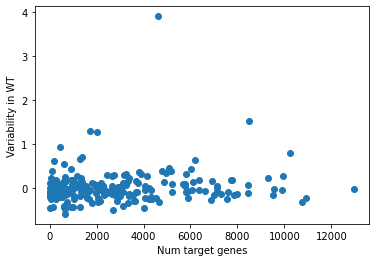

In [97]:
plt.scatter(merged['num_targets'], merged['KO_0'])
plt.xlabel('Num target genes'); plt.ylabel('Variability in WT')
# plt.ylim(-1,2)

### Run 1D memento for each guide

In [19]:
result_1d_dict = {}

In [ ]:
for g in guides:
    
    if g in result_1d_dict or 'INTER' in g or 'nan' in g:
        continue
    
    print(g)
    
    subset = adata[adata.obs.WT | (adata.obs.guides==g)].copy().copy()
    
    memento.create_groups(subset, label_columns=['KO'])
    memento.compute_1d_moments(subset, min_perc_group=.9)
    
    memento.ht_1d_moments(
        subset, 
        formula_like='1 + KO',
        cov_column='KO', 
        num_boot=10000, 
        verbose=1,
        num_cpus=14)
    
    result_1d_dict[g] = memento.get_1d_ht_result(subset)
    
    
    break

In [41]:
for g, result in result_1d_dict.items():
    
    result.to_csv(data_path + '/result_1d/{}.csv'.format(g), index=False)

### Get the change in magnitude for each guide

In [23]:
result_1d_dict = {g:pd.read_csv(data_path + '/result_1d/{}.csv'.format(g)) for g in guides if ('INTER' not in g and 'nan' not in g)}

In [52]:
coef_mag = []
for g, df in result_1d_dict.items():
    coef_mag.append((g, df['de_coef'].abs().median()))
coef_mag = pd.DataFrame(coef_mag, columns=['guide', 'de_mag'])
coef_mag['gene'] = coef_mag['guide'].str.split('_').str[1].str[2:]

### Get WT variability of each TF

In [126]:
wt_adata = adata[adata.obs['WT']].copy().copy()

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [127]:
tfs = adata.obs.query('KO==1').KO_GENE.drop_duplicates().tolist()

In [128]:
memento.create_groups(wt_adata, label_columns=['KO'])
memento.compute_1d_moments(wt_adata, min_perc_group=.9,)

In [129]:
tf_moments = memento.get_1d_moments(wt_adata, groupby='KO')

### Compare WT variability to De mag

In [53]:
merged = coef_mag.merge(tf_moments[1], on='gene')

In [58]:
stats.spearmanr(merged['de_mag'], merged['KO_0'])

SpearmanrResult(correlation=0.3045239982887388, pvalue=0.13038250961095305)

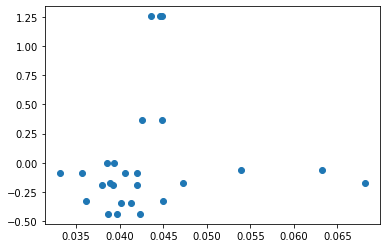

In [55]:
plt.scatter(merged['de_mag'], merged['KO_0'])

### Number of TF binding sites within 5k(?) KB


In [64]:
enc = encode.Encode('/home/ssm-user/Github/misc-seq/miscseq/GRCh38Genes.bed')

In [65]:
encode_links = {
    'ELK1':'https://www.encodeproject.org/files/ENCFF119SCQ/@@download/ENCFF119SCQ.bed.gz',
    'ELF1':'https://www.encodeproject.org/files/ENCFF133TSU/@@download/ENCFF133TSU.bed.gz',
    'IRF1':'https://www.encodeproject.org/files/ENCFF203LRV/@@download/ENCFF203LRV.bed.gz',
    'ETS1':'https://www.encodeproject.org/files/ENCFF461PRP/@@download/ENCFF461PRP.bed.gz',
    'EGR1':'https://www.encodeproject.org/files/ENCFF375RDB/@@download/ENCFF375RDB.bed.gz',
    'YY1':'https://www.encodeproject.org/files/ENCFF635XCI/@@download/ENCFF635XCI.bed.gz',
    'GABPA':'https://www.encodeproject.org/files/ENCFF173GUD/@@download/ENCFF173GUD.bed.gz',
    'E2F4':'https://www.encodeproject.org/files/ENCFF225TLP/@@download/ENCFF225TLP.bed.gz',
    'NR2C2':'https://www.encodeproject.org/files/ENCFF263VIC/@@download/ENCFF263VIC.bed.gz',
    'CREB1':'https://www.encodeproject.org/files/ENCFF193LLN/@@download/ENCFF193LLN.bed.gz'
}

In [ ]:
bed_objs = {tf:enc.get_encode_peaks(link) for tf,link in encode_links.items()}

In [ ]:
target_genes = {tf:enc.get_peak_genes_bed(bed_obj, 0).query('distance==0').gene.tolist() for tf, bed_obj in bed_objs.items()}

In [90]:
x = wt_adata[:, 'EGR1'].X.todense().A1

In [96]:
np.bincount(x.astype(int))

array([3771, 1004,  358,  121,   61,   28,   14,    9,    3,    3,    1,
          2,    3,    0,    1,    0,    0,    1,    0,    1])

In [97]:
x.mean()

0.5171901

(array([3.771e+03, 1.004e+03, 3.580e+02, 1.210e+02, 6.100e+01, 2.800e+01,
        1.400e+01, 9.000e+00, 3.000e+00, 3.000e+00, 1.000e+00, 2.000e+00,
        3.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00]),
 array([ 0.  ,  0.95,  1.9 ,  2.85,  3.8 ,  4.75,  5.7 ,  6.65,  7.6 ,
         8.55,  9.5 , 10.45, 11.4 , 12.35, 13.3 , 14.25, 15.2 , 16.15,
        17.1 , 18.05, 19.  ], dtype=float32),
 <BarContainer object of 20 artists>)

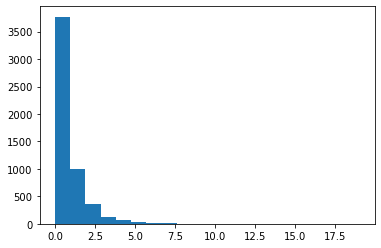

In [92]:
plt.hist(x, bins=20)

In [83]:
target_numbers = []
for tf in encode_links.keys():
    target_numbers.append((tf, len(target_genes[tf])))
target_numbers = pd.DataFrame(target_numbers, columns=['gene', 'num_targets'])

In [85]:
merged = target_numbers.merge(tf_moments[1], on='gene')

In [99]:
stats.pearsonr(merged.query('gene != "EGR1"')['num_targets'], merged.query('gene != "EGR1"')['KO_0'])

(-0.5965615744656985, 0.08993665159255994)

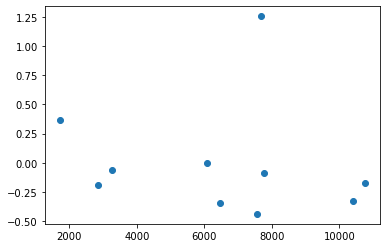

In [86]:
plt.scatter(merged['num_targets'], merged['KO_0'])

### Try with all ENCODE

In [130]:
merged

,gene,num_targets,KO_0
0,ELK1,2841,-0.187563
1,ELF1,7780,-0.083915
2,IRF1,1730,0.368231
3,ETS1,6077,-0.002687
4,EGR1,7679,1.255817
5,YY1,3274,-0.065112
6,GABPA,10399,-0.330720
7,E2F4,6457,-0.344105
8,NR2C2,10743,-0.170951
9,CREB1,7554,-0.438995


In [111]:
all_encode = pd.read_csv('gene_attribute_matrix.txt', sep='\t', index_col=0, low_memory=False).iloc[2:, 2:].astype(float)

In [124]:
target_counts = pd.DataFrame(all_encode.sum(axis=0), columns=['num_targets']).reset_index().rename(columns={'index':'gene'})

In [133]:
x = target_counts.query('gene in @tfs').sort_values('gene')['num_targets']
y = merged.sort_values('gene')['num_targets']

In [136]:
merged2 = target_counts.merge(tf_moments[1], on='gene')

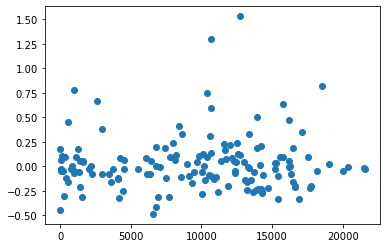

In [141]:
plt.scatter(merged2['num_targets'], merged2['KO_0'])

In [137]:
merged2

,gene,num_targets,KO_0
0,ARID3A,11708.0,0.073099
1,ATF1,6396.0,0.051094
2,ATF2,10102.0,0.129260
3,ATF3,8397.0,0.406496
4,BACH1,12451.0,0.040698
...,...,...,...
144,ZNF217,1430.0,0.054393
145,ZNF263,10671.0,-0.094167
146,ZNF274,970.0,-0.073136
147,ZNF384,13485.0,-0.136661


### Get gene list

In [116]:
wt_adata = adata[adata.obs['WT']].copy().copy()

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [117]:
memento.create_groups(wt_adata, label_columns=['KO'])
memento.compute_1d_moments(wt_adata, min_perc_group=.9)

(array([1912., 2444., 2211., 1365.,  742.,  312.,  100.,   58.,   40.,
          14.]),
 array([-2.7309983, -1.884943 , -1.0388877, -0.1928324,  0.6532229,
         1.4992782,  2.3453336,  3.1913888,  4.037444 ,  4.883499 ,
         5.7295547], dtype=float32),
 <BarContainer object of 10 artists>)

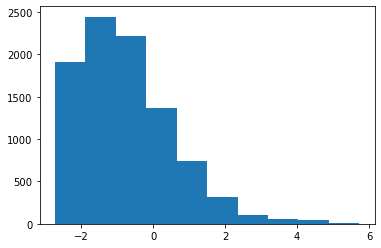

In [120]:
plt.hist(np.log(wt_adata.uns['memento']['1d_moments']['sg^0'][0]))

In [121]:
wt_high_genes = wt_adata.var.index[np.log(wt_adata.uns['memento']['1d_moments']['sg^0'][0]) > -1].tolist()

### Create labels for X genes

In [9]:
chr_locations = pd.read_csv('chr_locations.bed', sep='\t').rename(columns={'#chrom':'chr'}).drop_duplicates('geneName')

In [10]:
chr_locations.index=chr_locations.geneName

In [11]:
adata.var = adata.var.join(chr_locations, how='left')

### Filter X-chromosomal genes

In [14]:
adata_X = adata[:, (adata.var.chr=='chrX') | adata.var.chr.isin(['chr1', 'chr2', 'chr3'])].copy()

In [15]:
adata_X

AnnData object with n_obs × n_vars = 40183 × 5531
    obs: 'BatchL0_x', 'BatchL1_x', 'BatchL2_x', 'BatchL3_x', 'Prob(doublet)', 'age', 'batch', 'batch_cov', 'disease_cov', 'ind_cov', 'pop_cov', 'sex', 'study', 'Genotype ID', 'Old Genotype ID', 'Study_ID', 'Status', 'Age', 'Sex', 'Ethnicity', 'Study', 'BatchL0_y', 'BatchL1_y', 'BatchL2_y', 'BatchL3_y', 'Vicell', 'Cells Collected', 'Tubes', 'Concentration', 'Unnamed: 16', 'Processing_Cohort', 'n_genes', 'platelet', 'rbc', 'louvain', 'ct_cov', 'cg_cov', 'ind_cov_pop_cov', 'pop_cov_disease_cov', 'ind_cov_pop_cov_cohort', 'pop_cov_cohort_disease_cov', 'ind_cov_batch_cov', 'pop_cov_SLE_status', 'pop_cov_cohort_SLE_status', 'SLE_status', 'ind_cov_cohort', 'umap_density_disease_cov', 'umap_density_SLE_status', 'umap_density_pop_cov_SLE_status', 'q', 'memento_size_factor'
    var: 'gene_ids', 'feature_types-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0', 'chr', 'n

### Escape genes

In [16]:
par_genes = """PLCXD1 GTPBP6 PPP2R3B SHOX CRLF2 CSF2RA IL3RA SLC25A6 ASMTL P2RY8 ASMT DHRSXY ZBED1 CD99 XG IL9R SPRY3 VAMP7""".split()

In [17]:
escape_genes = """EIF1AX
USP9X
EIF2S3
CTPS2
TRAPPC2
HDHD1
ZFX
DDX3X
RAB9A
AP1S2
GEMIN8
RPS4X
SMC1A
ZRSR2
STS
FUNDC1
PNPLA4
UBA1
ARSD
NLGN4X
GPM6B
MED14
CD99
RBBP7
SYAP1
PRKX
OFD1
CXorf38
TXLNG
KDM5C
GYG2
TBL1X
CA5B
XIST
RENBP
HCFC1
USP11
PLCXD1
SLC25A6
ASMTL
DHRSX
XG
TMEM27
ARHGAP4
GAB3
PIR
TMEM187
DOCK11
EFHC2
RIBC1
NAP1L3
CA5BP1
MXRA5
KAL1
PCDH11X
KDM6A
PLS3
CITED1
L1CAM
ALG13
BCOR""".split()

### Run 1d memento

In [18]:
adata_X.obs['is_female'] = (adata_X.obs['Sex'] == 'Female').astype(int)

In [19]:
adata_X.obs.is_female.value_counts()

1    20676
0    19507
Name: is_female, dtype: int64

In [20]:
memento.create_groups(adata_X, label_columns=['is_female', 'ind_cov'])
memento.compute_1d_moments(adata_X, min_perc_group=.9)

/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.5-py3.8.egg/memento/estimator.py:105: RuntimeWarning: invalid value encountered in log


In [21]:
memento.ht_1d_moments(
    adata_X, 
    formula_like='1 + is_female',
    cov_column='is_female', 
    num_boot=20000, 
    verbose=1,
    num_cpus=13)

[Parallel(n_jobs=13)]: Using backend LokyBackend with 13 concurrent workers.
[Parallel(n_jobs=13)]: Done  24 tasks      | elapsed:   12.5s
[Parallel(n_jobs=13)]: Done 174 tasks      | elapsed:  1.3min
[Parallel(n_jobs=13)]: Done 424 tasks      | elapsed:  2.7min
[Parallel(n_jobs=13)]: Done 494 out of 494 | elapsed:  3.4min finished


In [22]:
result_1d = memento.get_1d_ht_result(adata_X)

In [23]:
result_1d['dv_fdr'] = memento.util._fdrcorrect(result_1d['dv_pval'])

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='dv_coef', ylabel='Density'>

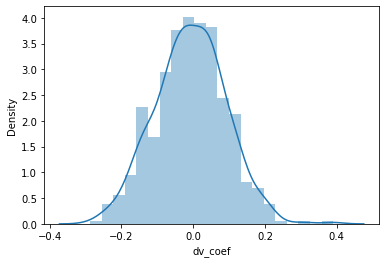

In [24]:
sns.distplot(result_1d.dv_coef)

In [29]:
x_chr_genes = adata.var.index[adata.var.chr=='chrX'].tolist()

In [30]:
result_1d['escape'] = result_1d['gene'].isin(escape_genes)
result_1d['par'] = result_1d['gene'].isin(par_genes)
result_1d['x_chr'] = result_1d['gene'].isin(x_chr_genes)

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='dv_coef', ylabel='Density'>

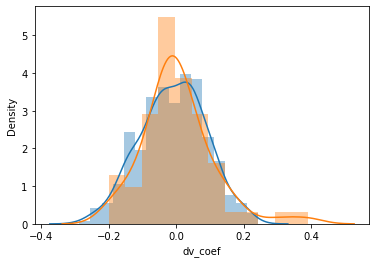

In [39]:
sns.distplot(result_1d.query('~x_chr').dv_coef)
sns.distplot(result_1d.query('x_chr').dv_coef)


<AxesSubplot:xlabel='x_chr', ylabel='dv_coef'>

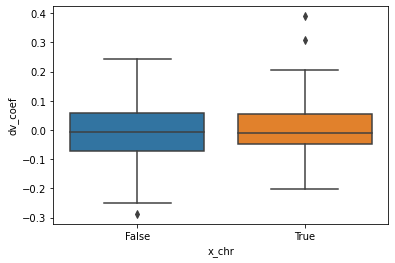

In [33]:
sns.boxplot(x='x_chr', y='dv_coef', data=result_1d)

In [43]:
dv_genes = result_1d.query('dv_fdr < 0.1').gene.tolist()

In [44]:
result_1d['dv'] = result_1d.gene.isin(dv_genes)

In [64]:
result_1d.query('~dv & ~x_chr & dv_coef > 0').shape

(193, 12)

In [65]:
a = [[193, 14],
 [23,5]]

In [66]:
stats.chi2_contingency(a)

(2.728208603147025,
 0.09858981341187181,
 1,
 array([[190.26382979,  16.73617021],
        [ 25.73617021,   2.26382979]]))

In [40]:
result_1d.query('dv_fdr < 0.1').x_chr.mean()

0.23809523809523808

In [41]:
result_1d.x_chr.mean()

0.12753036437246965

### Run memento for each subset, comparing to control

In [14]:
cts = [['ciliated'], ['bc','basal']]
# tps = ['3', '6', '9', '24', '48']
tps = ['3', '6', '9', '24', '48']

stims = ['alpha', 'beta', 'gamma', 'lambda']

In [15]:
import os
done_files = os.listdir('/data_volume/ifn_hbec/binary_test_deep/')

In [16]:
for ct in cts:
    for tp in tps:
        for stim in stims:
            
            fname = '{}_{}_{}_20200320.h5ad'.format('-'.join(ct), stim, tp)
            
            if fname in done_files:
                print('Skipping', fname)
                continue

            print('starting', ct, tp, stim)

            adata_stim = adata.copy()[
                adata.obs.cell_type.isin(ct) & \
                adata.obs.stim.isin(['control', stim]) & \
                adata.obs.time.isin(['0',tp]), :].copy()
            time_converter={0:0, int(tp):1}
            adata_stim.obs['time_step'] = adata_stim.obs['time'].astype(int).apply(lambda x: time_converter[x])

            memento.create_groups(adata_stim, label_columns=['time_step', 'donor'])
            memento.compute_1d_moments(adata_stim, min_perc_group=.9)

            memento.ht_1d_moments(
                adata_stim, 
                formula_like='1 + time_step',
                cov_column='time_step', 
                num_boot=10000, 
                verbose=1,
                num_cpus=13)

            del adata_stim.uns['memento']['mv_regressor']

            adata_stim.write('/data_volume/ifn_hbec/binary_test_deep/{}_{}_{}_20200320.h5ad'.format(
                '-'.join(ct), stim, tp))

starting ['ciliated'] 3 alpha


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=13)]: Using backend LokyBackend with 13 concurrent workers.
[Parallel(n_jobs=13)]: Done  24 tasks      | elapsed:    3.2s
[Parallel(n_jobs=13)]: Done 174 tasks      | elapsed:    8.2s
[Parallel(n_jobs=13)]: Done 424 tasks      | elapsed:   17.9s
[Parallel(n_jobs=13)]: Done 774 tasks      | elapsed:   30.8s
[Parallel(n_jobs=13)]: Done 1224 tasks      | elapsed:   46.7s
[Parallel(n_jobs=13)]: Done 1774 tasks      | elapsed:  1.1min
[Parallel(n_jobs=13)]: Done 2424 tasks      | elapsed:  1.5min
[Parallel(n_jobs=13)]: Done 3174 tasks      | elapsed:  1.9min
[Parallel(n_jobs=13)]: Done 4024 tasks      | elapsed:  2.4min
[Parallel(n_jobs=13)]: Done 4974 tasks      | elapsed:  3.0min
[Parallel(n_jo

starting ['ciliated'] 3 beta


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=13)]: Using backend LokyBackend with 13 concurrent workers.
[Parallel(n_jobs=13)]: Done  24 tasks      | elapsed:    1.1s
[Parallel(n_jobs=13)]: Done 174 tasks      | elapsed:    5.9s
[Parallel(n_jobs=13)]: Done 424 tasks      | elapsed:   14.8s
[Parallel(n_jobs=13)]: Done 774 tasks      | elapsed:   27.3s
[Parallel(n_jobs=13)]: Done 1224 tasks      | elapsed:   42.4s
[Parallel(n_jobs=13)]: Done 1774 tasks      | elapsed:  1.0min
[Parallel(n_jobs=13)]: Done 2424 tasks      | elapsed:  1.4min
[Parallel(n_jobs=13)]: Done 3174 tasks      | elapsed:  1.8min
[Parallel(n_jobs=13)]: Done 4024 tasks      | elapsed:  2.3min
[Parallel(n_jobs=13)]: Done 4974 tasks      | elapsed:  2.8min
[Parallel(n_jo

starting ['ciliated'] 3 gamma


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=13)]: Using backend LokyBackend with 13 concurrent workers.
[Parallel(n_jobs=13)]: Done  24 tasks      | elapsed:    0.9s
[Parallel(n_jobs=13)]: Done 174 tasks      | elapsed:    5.2s
[Parallel(n_jobs=13)]: Done 424 tasks      | elapsed:   12.7s
[Parallel(n_jobs=13)]: Done 774 tasks      | elapsed:   23.4s
[Parallel(n_jobs=13)]: Done 1224 tasks      | elapsed:   36.4s
[Parallel(n_jobs=13)]: Done 1774 tasks      | elapsed:   52.3s
[Parallel(n_jobs=13)]: Done 2424 tasks      | elapsed:  1.2min
[Parallel(n_jobs=13)]: Done 3174 tasks      | elapsed:  1.5min
[Parallel(n_jobs=13)]: Done 4024 tasks      | elapsed:  2.0min
[Parallel(n_jobs=13)]: Done 4974 tasks      | elapsed:  2.4min
[Parallel(n_jo

starting ['ciliated'] 3 lambda


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=13)]: Using backend LokyBackend with 13 concurrent workers.
[Parallel(n_jobs=13)]: Done  24 tasks      | elapsed:    1.0s
[Parallel(n_jobs=13)]: Done 174 tasks      | elapsed:    5.2s
[Parallel(n_jobs=13)]: Done 424 tasks      | elapsed:   13.1s
[Parallel(n_jobs=13)]: Done 774 tasks      | elapsed:   23.7s
[Parallel(n_jobs=13)]: Done 1224 tasks      | elapsed:   36.7s
[Parallel(n_jobs=13)]: Done 1774 tasks      | elapsed:   52.6s
[Parallel(n_jobs=13)]: Done 2424 tasks      | elapsed:  1.2min
[Parallel(n_jobs=13)]: Done 3174 tasks      | elapsed:  1.6min
[Parallel(n_jobs=13)]: Done 4024 tasks      | elapsed:  2.0min
[Parallel(n_jobs=13)]: Done 4974 tasks      | elapsed:  2.4min
[Parallel(n_jo

starting ['ciliated'] 6 alpha


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=13)]: Using backend LokyBackend with 13 concurrent workers.
[Parallel(n_jobs=13)]: Done  24 tasks      | elapsed:    1.1s
[Parallel(n_jobs=13)]: Done 174 tasks      | elapsed:    5.7s
[Parallel(n_jobs=13)]: Done 424 tasks      | elapsed:   14.3s
[Parallel(n_jobs=13)]: Done 774 tasks      | elapsed:   27.0s
[Parallel(n_jobs=13)]: Done 1224 tasks      | elapsed:   42.2s
[Parallel(n_jobs=13)]: Done 1774 tasks      | elapsed:  1.0min
[Parallel(n_jobs=13)]: Done 2424 tasks      | elapsed:  1.4min
[Parallel(n_jobs=13)]: Done 3174 tasks      | elapsed:  1.8min
[Parallel(n_jobs=13)]: Done 4024 tasks      | elapsed:  2.3min
[Parallel(n_jobs=13)]: Done 4974 tasks      | elapsed:  2.8min
[Parallel(n_jo

starting ['ciliated'] 6 beta


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=13)]: Using backend LokyBackend with 13 concurrent workers.
[Parallel(n_jobs=13)]: Done  24 tasks      | elapsed:    1.1s
[Parallel(n_jobs=13)]: Done 174 tasks      | elapsed:    5.9s
[Parallel(n_jobs=13)]: Done 424 tasks      | elapsed:   15.0s
[Parallel(n_jobs=13)]: Done 774 tasks      | elapsed:   28.7s
[Parallel(n_jobs=13)]: Done 1224 tasks      | elapsed:   44.8s
[Parallel(n_jobs=13)]: Done 1774 tasks      | elapsed:  1.1min
[Parallel(n_jobs=13)]: Done 2424 tasks      | elapsed:  1.5min
[Parallel(n_jobs=13)]: Done 3174 tasks      | elapsed:  1.9min
[Parallel(n_jobs=13)]: Done 4024 tasks      | elapsed:  2.4min
[Parallel(n_jobs=13)]: Done 4974 tasks      | elapsed:  3.0min
[Parallel(n_jo

starting ['ciliated'] 6 gamma


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=13)]: Using backend LokyBackend with 13 concurrent workers.
[Parallel(n_jobs=13)]: Done  24 tasks      | elapsed:    1.0s
[Parallel(n_jobs=13)]: Done 174 tasks      | elapsed:    5.0s
[Parallel(n_jobs=13)]: Done 424 tasks      | elapsed:   12.6s
[Parallel(n_jobs=13)]: Done 774 tasks      | elapsed:   23.3s
[Parallel(n_jobs=13)]: Done 1224 tasks      | elapsed:   36.3s
[Parallel(n_jobs=13)]: Done 1774 tasks      | elapsed:   52.1s
[Parallel(n_jobs=13)]: Done 2424 tasks      | elapsed:  1.2min
[Parallel(n_jobs=13)]: Done 3174 tasks      | elapsed:  1.5min
[Parallel(n_jobs=13)]: Done 4024 tasks      | elapsed:  1.9min
[Parallel(n_jobs=13)]: Done 4974 tasks      | elapsed:  2.4min
[Parallel(n_jo

starting ['ciliated'] 6 lambda


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=13)]: Using backend LokyBackend with 13 concurrent workers.
[Parallel(n_jobs=13)]: Done  24 tasks      | elapsed:    1.0s
[Parallel(n_jobs=13)]: Done 322 tasks      | elapsed:    9.2s
[Parallel(n_jobs=13)]: Done 822 tasks      | elapsed:   24.0s
[Parallel(n_jobs=13)]: Done 1522 tasks      | elapsed:   43.3s
[Parallel(n_jobs=13)]: Done 2422 tasks      | elapsed:  1.1min
[Parallel(n_jobs=13)]: Done 3522 tasks      | elapsed:  1.6min
[Parallel(n_jobs=13)]: Done 4822 tasks      | elapsed:  2.2min
[Parallel(n_jobs=13)]: Done 6322 tasks      | elapsed:  3.0min
[Parallel(n_jobs=13)]: Done 8022 tasks      | elapsed:  3.7min
[Parallel(n_jobs=13)]: Done 9277 tasks      | elapsed:  4.3min
[Parallel(n_j

starting ['ciliated'] 9 alpha


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=13)]: Using backend LokyBackend with 13 concurrent workers.
[Parallel(n_jobs=13)]: Done  24 tasks      | elapsed:    1.0s
[Parallel(n_jobs=13)]: Done 174 tasks      | elapsed:    5.4s
[Parallel(n_jobs=13)]: Done 424 tasks      | elapsed:   13.6s
[Parallel(n_jobs=13)]: Done 774 tasks      | elapsed:   24.8s
[Parallel(n_jobs=13)]: Done 1224 tasks      | elapsed:   38.9s
[Parallel(n_jobs=13)]: Done 1774 tasks      | elapsed:   55.8s
[Parallel(n_jobs=13)]: Done 2424 tasks      | elapsed:  1.3min
[Parallel(n_jobs=13)]: Done 3174 tasks      | elapsed:  1.7min
[Parallel(n_jobs=13)]: Done 4024 tasks      | elapsed:  2.1min
[Parallel(n_jobs=13)]: Done 4974 tasks      | elapsed:  2.6min
[Parallel(n_jo

starting ['ciliated'] 9 beta


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=13)]: Using backend LokyBackend with 13 concurrent workers.
[Parallel(n_jobs=13)]: Done  24 tasks      | elapsed:    1.2s
[Parallel(n_jobs=13)]: Done 322 tasks      | elapsed:    9.8s
[Parallel(n_jobs=13)]: Done 762 tasks      | elapsed:   22.9s
[Parallel(n_jobs=13)]: Done 1112 tasks      | elapsed:   33.0s
[Parallel(n_jobs=13)]: Done 1562 tasks      | elapsed:   46.1s
[Parallel(n_jobs=13)]: Done 2112 tasks      | elapsed:  1.0min
[Parallel(n_jobs=13)]: Done 2762 tasks      | elapsed:  1.3min
[Parallel(n_jobs=13)]: Done 3512 tasks      | elapsed:  1.7min
[Parallel(n_jobs=13)]: Done 4362 tasks      | elapsed:  2.1min
[Parallel(n_jobs=13)]: Done 5312 tasks      | elapsed:  2.6min
[Parallel(n_j

starting ['ciliated'] 9 gamma


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=13)]: Using backend LokyBackend with 13 concurrent workers.
[Parallel(n_jobs=13)]: Done  24 tasks      | elapsed:    0.9s
[Parallel(n_jobs=13)]: Done 174 tasks      | elapsed:    4.7s
[Parallel(n_jobs=13)]: Done 424 tasks      | elapsed:   12.2s
[Parallel(n_jobs=13)]: Done 774 tasks      | elapsed:   22.5s
[Parallel(n_jobs=13)]: Done 1224 tasks      | elapsed:   35.1s
[Parallel(n_jobs=13)]: Done 1774 tasks      | elapsed:   50.5s
[Parallel(n_jobs=13)]: Done 2424 tasks      | elapsed:  1.2min
[Parallel(n_jobs=13)]: Done 3174 tasks      | elapsed:  1.5min
[Parallel(n_jobs=13)]: Done 4024 tasks      | elapsed:  1.9min
[Parallel(n_jobs=13)]: Done 4974 tasks      | elapsed:  2.3min
[Parallel(n_jo

starting ['ciliated'] 9 lambda


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=13)]: Using backend LokyBackend with 13 concurrent workers.
[Parallel(n_jobs=13)]: Done  24 tasks      | elapsed:    0.9s
[Parallel(n_jobs=13)]: Done 174 tasks      | elapsed:    4.7s
[Parallel(n_jobs=13)]: Done 424 tasks      | elapsed:   12.2s
[Parallel(n_jobs=13)]: Done 774 tasks      | elapsed:   22.7s
[Parallel(n_jobs=13)]: Done 1224 tasks      | elapsed:   35.2s
[Parallel(n_jobs=13)]: Done 1774 tasks      | elapsed:   50.7s
[Parallel(n_jobs=13)]: Done 2424 tasks      | elapsed:  1.2min
[Parallel(n_jobs=13)]: Done 3174 tasks      | elapsed:  1.5min
[Parallel(n_jobs=13)]: Done 4024 tasks      | elapsed:  1.9min
[Parallel(n_jobs=13)]: Done 4974 tasks      | elapsed:  2.3min
[Parallel(n_jo

starting ['ciliated'] 24 alpha


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=13)]: Using backend LokyBackend with 13 concurrent workers.
[Parallel(n_jobs=13)]: Done  24 tasks      | elapsed:    0.9s
[Parallel(n_jobs=13)]: Done 174 tasks      | elapsed:    4.9s
[Parallel(n_jobs=13)]: Done 424 tasks      | elapsed:   12.3s
[Parallel(n_jobs=13)]: Done 774 tasks      | elapsed:   23.5s
[Parallel(n_jobs=13)]: Done 1224 tasks      | elapsed:   36.6s
[Parallel(n_jobs=13)]: Done 1774 tasks      | elapsed:   52.9s
[Parallel(n_jobs=13)]: Done 2424 tasks      | elapsed:  1.2min
[Parallel(n_jobs=13)]: Done 3174 tasks      | elapsed:  1.6min
[Parallel(n_jobs=13)]: Done 4024 tasks      | elapsed:  2.0min
[Parallel(n_jobs=13)]: Done 4974 tasks      | elapsed:  2.5min
[Parallel(n_jo

starting ['ciliated'] 24 beta


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=13)]: Using backend LokyBackend with 13 concurrent workers.
[Parallel(n_jobs=13)]: Done  24 tasks      | elapsed:    0.9s
[Parallel(n_jobs=13)]: Done 174 tasks      | elapsed:    5.0s
[Parallel(n_jobs=13)]: Done 424 tasks      | elapsed:   12.9s
[Parallel(n_jobs=13)]: Done 774 tasks      | elapsed:   24.1s
[Parallel(n_jobs=13)]: Done 1224 tasks      | elapsed:   37.4s
[Parallel(n_jobs=13)]: Done 1774 tasks      | elapsed:   53.7s
[Parallel(n_jobs=13)]: Done 2424 tasks      | elapsed:  1.2min
[Parallel(n_jobs=13)]: Done 3174 tasks      | elapsed:  1.6min
[Parallel(n_jobs=13)]: Done 4024 tasks      | elapsed:  2.0min
[Parallel(n_jobs=13)]: Done 4974 tasks      | elapsed:  2.5min
[Parallel(n_jo

starting ['ciliated'] 24 gamma


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=13)]: Using backend LokyBackend with 13 concurrent workers.
[Parallel(n_jobs=13)]: Done  24 tasks      | elapsed:    0.9s
[Parallel(n_jobs=13)]: Done 174 tasks      | elapsed:    4.9s
[Parallel(n_jobs=13)]: Done 424 tasks      | elapsed:   12.8s
[Parallel(n_jobs=13)]: Done 774 tasks      | elapsed:   23.8s
[Parallel(n_jobs=13)]: Done 1224 tasks      | elapsed:   37.2s
[Parallel(n_jobs=13)]: Done 1774 tasks      | elapsed:   53.4s
[Parallel(n_jobs=13)]: Done 2424 tasks      | elapsed:  1.2min
[Parallel(n_jobs=13)]: Done 3174 tasks      | elapsed:  1.6min
[Parallel(n_jobs=13)]: Done 4024 tasks      | elapsed:  2.0min
[Parallel(n_jobs=13)]: Done 4974 tasks      | elapsed:  2.5min
[Parallel(n_jo

starting ['ciliated'] 24 lambda


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=13)]: Using backend LokyBackend with 13 concurrent workers.
[Parallel(n_jobs=13)]: Done  24 tasks      | elapsed:    0.9s
[Parallel(n_jobs=13)]: Done 174 tasks      | elapsed:    4.9s
[Parallel(n_jobs=13)]: Done 424 tasks      | elapsed:   12.5s
[Parallel(n_jobs=13)]: Done 774 tasks      | elapsed:   23.1s
[Parallel(n_jobs=13)]: Done 1224 tasks      | elapsed:   35.9s
[Parallel(n_jobs=13)]: Done 1774 tasks      | elapsed:   51.8s
[Parallel(n_jobs=13)]: Done 2424 tasks      | elapsed:  1.2min
[Parallel(n_jobs=13)]: Done 3174 tasks      | elapsed:  1.5min
[Parallel(n_jobs=13)]: Done 4024 tasks      | elapsed:  2.0min
[Parallel(n_jobs=13)]: Done 4974 tasks      | elapsed:  2.4min
[Parallel(n_jo

starting ['ciliated'] 48 alpha


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=13)]: Using backend LokyBackend with 13 concurrent workers.
[Parallel(n_jobs=13)]: Done  24 tasks      | elapsed:    0.8s
[Parallel(n_jobs=13)]: Done 174 tasks      | elapsed:    4.6s
[Parallel(n_jobs=13)]: Done 424 tasks      | elapsed:   11.9s
[Parallel(n_jobs=13)]: Done 774 tasks      | elapsed:   22.4s
[Parallel(n_jobs=13)]: Done 1224 tasks      | elapsed:   34.8s
[Parallel(n_jobs=13)]: Done 1774 tasks      | elapsed:   49.7s
[Parallel(n_jobs=13)]: Done 2424 tasks      | elapsed:  1.1min
[Parallel(n_jobs=13)]: Done 3174 tasks      | elapsed:  1.5min
[Parallel(n_jobs=13)]: Done 4024 tasks      | elapsed:  1.9min
[Parallel(n_jobs=13)]: Done 4974 tasks      | elapsed:  2.3min
[Parallel(n_jo

starting ['ciliated'] 48 beta


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=13)]: Using backend LokyBackend with 13 concurrent workers.
[Parallel(n_jobs=13)]: Done  24 tasks      | elapsed:    0.8s
[Parallel(n_jobs=13)]: Done 322 tasks      | elapsed:    9.0s
[Parallel(n_jobs=13)]: Done 822 tasks      | elapsed:   23.2s
[Parallel(n_jobs=13)]: Done 1522 tasks      | elapsed:   42.1s
[Parallel(n_jobs=13)]: Done 2422 tasks      | elapsed:  1.1min
[Parallel(n_jobs=13)]: Done 3522 tasks      | elapsed:  1.6min
[Parallel(n_jobs=13)]: Done 4822 tasks      | elapsed:  2.2min
[Parallel(n_jobs=13)]: Done 6322 tasks      | elapsed:  2.9min
[Parallel(n_jobs=13)]: Done 8022 tasks      | elapsed:  3.6min
[Parallel(n_jobs=13)]: Done 9436 out of 9461 | elapsed:  4.3min remaining:  

starting ['ciliated'] 48 gamma


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=13)]: Using backend LokyBackend with 13 concurrent workers.
[Parallel(n_jobs=13)]: Done  24 tasks      | elapsed:    0.9s
[Parallel(n_jobs=13)]: Done 174 tasks      | elapsed:    4.7s
[Parallel(n_jobs=13)]: Done 424 tasks      | elapsed:   11.9s
[Parallel(n_jobs=13)]: Done 774 tasks      | elapsed:   22.1s
[Parallel(n_jobs=13)]: Done 1224 tasks      | elapsed:   34.4s
[Parallel(n_jobs=13)]: Done 1774 tasks      | elapsed:   49.5s
[Parallel(n_jobs=13)]: Done 2424 tasks      | elapsed:  1.1min
[Parallel(n_jobs=13)]: Done 3174 tasks      | elapsed:  1.5min
[Parallel(n_jobs=13)]: Done 4024 tasks      | elapsed:  1.9min
[Parallel(n_jobs=13)]: Done 4974 tasks      | elapsed:  2.3min
[Parallel(n_jo

starting ['ciliated'] 48 lambda


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=13)]: Using backend LokyBackend with 13 concurrent workers.
[Parallel(n_jobs=13)]: Done  24 tasks      | elapsed:    1.1s
[Parallel(n_jobs=13)]: Done 322 tasks      | elapsed:    9.2s
[Parallel(n_jobs=13)]: Done 822 tasks      | elapsed:   23.6s
[Parallel(n_jobs=13)]: Done 1522 tasks      | elapsed:   42.9s
[Parallel(n_jobs=13)]: Done 2212 tasks      | elapsed:  1.0min
[Parallel(n_jobs=13)]: Done 2762 tasks      | elapsed:  1.3min
[Parallel(n_jobs=13)]: Done 3412 tasks      | elapsed:  1.6min
[Parallel(n_jobs=13)]: Done 4162 tasks      | elapsed:  1.9min
[Parallel(n_jobs=13)]: Done 5012 tasks      | elapsed:  2.3min
[Parallel(n_jobs=13)]: Done 5962 tasks      | elapsed:  2.8min
[Parallel(n_j